## Preprocess Data

In [1]:
import pandas as pd
data = pd.read_csv('./High-School_data_2013.csv', header = None, delimiter='\t')
stream = data[0]

def order(link):
    begin = link[0]
    end = link[1]
    s = link[2] + link[3]
    s = int(s)
    return s*1000000**2 + begin*1000000 + end 

def time_order(link):
    return link[0] * 1000000 + link[1]

min_time = 1385982000
unprocessed_links_stream = []
for line in stream:
    time, s1, s2 = line.split(' ')[0:3]
    time = int(time) - min_time
    if int(s1) > int(s2):
        temp = s1
        s1 = s2
        s2 = temp
    link = [time - 20, time, s1, s2]
    unprocessed_links_stream.append(link)
links_stream = sorted(unprocessed_links_stream, key=order)

In [2]:
stream = {}
merge_step = 20
for link in links_stream:
    pair = (link[2], link[3])
    if pair not in stream:
        stream.update({pair : [[link[0], link[1]]]})
    else:
        if stream[pair][-1][1] + merge_step >= link[0]:
            stream[pair][-1][1] = link[1]
        else:
            stream[pair].append([link[0], link[1]])

In [3]:
links_stream = []
for pair in stream:
    for interval in stream[pair]:
        links_stream.append([interval[0], interval[1], pair[0], pair[1]])

## Merge 2 Edges

In [4]:
def difference(pair1, pair2):
    a = pair1[0]
    b = pair2[0]
    c = pair1[1]
    d = pair2[1]
    if a == b:
        return (c, d)
    elif b == c:
        return (a, d)
    elif c == d:
        return (a, b)
    else:
        return (b, c)

def reverse(pair):
    return (pair[1], pair[0])

In [5]:
links_stream = sorted(links_stream, key = time_order)

In [6]:
# add link
extended_stream = []
for i in range(len(links_stream)):
    l1 = links_stream[i]
    for j in range(i+1, len(links_stream)):
        l2 = links_stream[j]
        if l2[0] >= l1[1]:
            break
        begin = l2[0]
        end = min(l1[1], l2[1])
        
        s1 = (l1[2], l1[3])
        s2 = (l2[2], l2[3])
        if not all(v in s1 for v in s2) and any(v in s1 for v in s2):
            pair = difference(s1, s2)
            if int(pair[0]) > int(pair[1]):
                pair = reverse(pair)
            if pair in stream:
                overlap = False
                for interval in stream[pair]:
                    if interval[1] <= begin:
                        continue
                    elif interval[0] >= end:
                        break
                    else:
                        overlap = True
                        break
                if not overlap:
                    extended_stream.append([begin, end, pair[0], pair[1]])
            else:
                extended_stream.append([begin, end, pair[0], pair[1]])

In [7]:
for link in links_stream:
    extended_stream.append(link)
extended_stream = sorted(extended_stream, key = order)

In [8]:
k_stream = {}
for link in extended_stream:
    pair = (link[2], link[3])
    if pair not in k_stream:
        k_stream.update({pair : [[link[0], link[1]]]})
    else:
        if k_stream[pair][-1][1] + merge_step >= link[0]:
            k_stream[pair][-1][1] = link[1]
        else:
            k_stream[pair].append([link[0], link[1]])

In [9]:
extended_stream = []
for pair in k_stream:
    for interval in k_stream[pair]:
        extended_stream.append([interval[0], interval[1], pair[0], pair[1]])

In [10]:
extended_stream = sorted(extended_stream, key = time_order)

## Find Clique

In [11]:
import warnings
warnings.filterwarnings('ignore')
from CliqueMaster import CliqueMaster
from Clique import Clique
import os
import sys

def get_cliques(ls):
    Cm = CliqueMaster()
    times = dict()
    nodes = dict()
    nb_lines = 0
    resurrect = False
    
    omega = None
    old_b = None
    old_e = 0
    
    for link in ls:
        b = link[0]
        e = link[1]
        u = link[2]
        v = link[3]
        
        if omega == None or omega < e:
            omega = e


        link = frozenset([u, v])
        time = (b, b)

        # This a new instance
        Cm.addClique(Clique((link, time), set([])))

        # Populate data structures
        if link not in times:
            times[link] = []
        times[link].append((b,e))

        if u not in nodes:
            nodes[u] = set()

        if v not in nodes:
            nodes[v] = set()

        nodes[u].add(v)
        nodes[v].add(u)

        assert(b <= e)
        assert( (old_b == None) or (b >= old_b) )
        if b == old_b:
            assert(e >= old_e)

        (old_b,old_e) = (b,e)
        nb_lines = nb_lines + 1

    Cm._times = times
    Cm._nodes = nodes


    # Start execution
    R = Cm.getMaximalCliques(omega)
    return R

In [12]:
two_distance_clique = get_cliques(extended_stream)

In [13]:
len(two_distance_clique)

58338

## Finding maximal clique

In [14]:
def clique_time(clique):
    return clique._tb * 1000000 + clique._te

two_distance_clique = sorted(two_distance_clique, key = clique_time)

node_clique_dict = {}
i = 0
for clique in two_distance_clique:
    node_clique_dict.update({i : clique})
    i += 1

In [15]:
import networkx as nx
G = nx.DiGraph()
for key in node_clique_dict:
    G.add_node(key)

In [16]:
import time
counter = 0
start = time.time()
for i in range(len(G.node)):
    c1 = node_clique_dict[i]
    for j in range(len(G.node)):
        c2 = node_clique_dict[j]
        if c1 == c2 or c2._te <= c1._tb:
            continue
        if c2._tb >= c1._te:
            break
        elif c1._tb >= c2._tb and c1._te <= c2._te and all(x in c1._X for x in c2._X):
            G.add_edge(i, j)
    counter += 1
    if counter % 4000 == 0:
        end = time.time()
        print('step ' + str(counter) + ', time = ' + str(end - start))
        start = time.time()

step 4000, time = 4.352362155914307
step 8000, time = 12.828698635101318
step 12000, time = 22.873833656311035
step 16000, time = 35.24372625350952
step 20000, time = 46.59942960739136
step 24000, time = 59.57569360733032
step 28000, time = 69.11817955970764
step 32000, time = 78.76738095283508
step 36000, time = 87.6845314502716
step 40000, time = 100.88752675056458
step 44000, time = 114.72622776031494
step 48000, time = 128.27698373794556
step 52000, time = 132.95654344558716
step 56000, time = 145.46799111366272


In [20]:
def maximal_clique(graph):
    out_vertices = set()
    forbid = set()
    for edge in graph.edges:
        forbid.add(edge[1])
    
    for edge in graph.edges:
        if edge[0] not in forbid:
            out_vertices.add(edge[0])
    return out_vertices

In [21]:
out = maximal_clique(G)

In [24]:
def get_2_distance_clique(out_vertex):
    nodes = node_clique_dict[out_vertex]._X
    begin = node_clique_dict[out_vertex]._tb
    end = node_clique_dict[out_vertex]._te
    
    result = []
    for n1 in nodes:
        for n2 in nodes:
            if int(n1) >= int(n2):
                continue
            pair = (n1, n2)
            if pair in stream:
                for interval in stream[pair]:
                    if begin >= interval[0] and end <= interval[1]:
                        result.append([(n1, n2), interval[0], interval[1]])
                        break
    if result == []:
        print(nodes)
        print(begin)
        print(end)
    return result

In [25]:
tdc = []
for v in out:
    tdc.append(get_2_distance_clique(v))

frozenset({'496', '232', '453'})
259780
259780
frozenset({'21', '285', '172', '413'})
263400
263400
frozenset({'312', '339', '544'})
267020
267060
frozenset({'200', '45', '453'})
78960
78960
frozenset({'80', '322', '480'})
338780
338800
frozenset({'70', '425', '179'})
94240
94240
frozenset({'80', '826', '322', '488'})
346160
346180
frozenset({'201', '502', '38'})
346280
346300
frozenset({'179', '132', '101'})
349780
349820
frozenset({'85', '115', '190'})
165480
165640
frozenset({'3', '147', '884'})
169220
169300
frozenset({'276', '190', '213'})
175600
175600


In [29]:
tdc

[[[('227', '920'), 178080, 178360], [('32', '920'), 178200, 178280]],
 [[('255', '275'), 0, 20], [('122', '255'), 0, 60]],
 [[('170', '894'), 178220, 178260], [('170', '883'), 178180, 178400]],
 [[('151', '866'), 0, 140], [('54', '866'), 0, 400]],
 [[('4', '90'), 177420, 178760],
  [('4', '452'), 177960, 178900],
  [('90', '452'), 177800, 178300],
  [('90', '769'), 178200, 178500],
  [('90', '333'), 176920, 178560],
  [('333', '452'), 178260, 178440],
  [('333', '769'), 178180, 178420]],
 [[('279', '638'), 178300, 178320],
  [('638', '1543'), 177980, 178320],
  [('638', '1067'), 178260, 178320]],
 [[('634', '691'), 178120, 178340],
  [('634', '869'), 178240, 178460],
  [('691', '1332'), 178300, 178360],
  [('869', '1332'), 178320, 178480]],
 [[('564', '577'), 0, 40], [('577', '634'), 20, 60]],
 [[('279', '908'), 20, 40], [('279', '510'), 20, 100]],
 [[('4', '90'), 177420, 178760],
  [('4', '452'), 177960, 178900],
  [('4', '769'), 178340, 178420],
  [('4', '333'), 178340, 178500],
  [(

In [26]:
def begin_time(link):
    return link[1]

def overlap(a, b):
    if max(0, min(a[1], b[1]) - max(a[0], b[0])) > 0:
        return True
    else:
        return False
    
def activation_time(n, stream):
    result = []
    stream = sorted(stream, key = begin_time)
    for link in stream:
        if n in link[0]:
            i = [link[1], link[2]]
            ol = False
            for interval in result:
                if overlap(interval, i):
                    result.remove(interval)
                    result.append([min(i[0], interval[0]), max(i[1], interval[1])])
                    ol = True
                    break
            if not ol:
                result.append(i)
    return result

def intersect_activation_time(n1, n2, stream):
    t1 = activation_time(n1, stream)
    t2 = activation_time(n2, stream)
    result = 0
    for i1 in t1:
        for i2 in t2:
            result += max(0, min(i1[1], i2[1]) - max(i1[0], i2[0]))
    return result

In [75]:
def density(stream):
    nominator = 0
    for link in stream:
        nominator += link[2] - link[1]
    if nominator == 0:
        return 1
        
    denominator = 0
    vertices = set()
    for link in stream:
        vertices.add(link[0][0])
        vertices.add(link[0][1])
    for v1 in vertices:
        for v2 in vertices:
            if v1 == v2:
                continue
            denominator += intersect_activation_time(v1, v2, stream)

    denominator = denominator / 2

    return nominator / denominator

In [76]:
intersect_activation_time('227', '920', tdc[0])

280

In [77]:
density(tdc[0])

0.8181818181818182

In [78]:
activation_time('227', tdc[0])

[[178080, 178360]]

In [79]:
tdc[0]

[[('227', '920'), 178080, 178360], [('32', '920'), 178200, 178280]]

In [81]:
X = [density(s) for s in tdc]

In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

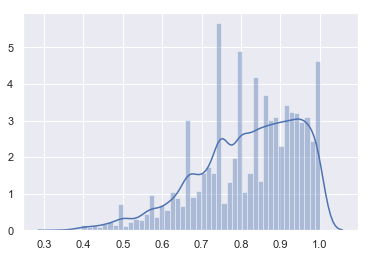

In [83]:
sns.set(color_codes=True)
sns.distplot(X)